In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
import shap

/home/tibbers/git/udacity_salaries/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Overview:</h1>
1. Load and analyze the data<br/>
2. Preprocessing<br/>
3. Fit a simple model and evaluate it<br/>
4. Fit a more complex model and evaluate it<br/>
5. Compare the 2 models<br/>
6. Analyze for feature importance <br/>
7. Draw conclusions

<h2>1. Load and analyze the data</h2>

In [2]:
survey = pd.read_csv("./survey_results_public.csv")
survey.shape

(49123, 170)

In [3]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49123 entries, 0 to 49122
Columns: 170 entries, ResponseId to JobSat
dtypes: float64(50), int64(1), object(119)
memory usage: 63.7+ MB


In [4]:
#there are many colums with different text values
survey.nunique().sort_values(kind="quicksort")[150:]

AIToolPlan to partially use AI     4459
CommPlatformWantToWorkWith         4780
DevEnvsWantToWorkWith              5408
DatabaseWantToWorkWith             5474
WebframeWantToWorkWith             5726
CommPlatformHaveWorkedWith         6102
ConvertedCompYearly                6234
DatabaseHaveWorkedWith             6664
OfficeStackAsyncHaveWorkedWith     6682
WebframeHaveWorkedWith             7412
DevEnvsHaveWorkedWith              7755
LanguageAdmired                    8080
PlatformAdmired                   11025
AIExplain                         11215
PlatformWantToWorkWith            13329
LanguageWantToWorkWith            13724
LanguageHaveWorkedWith            15467
PlatformHaveWorkedWith            18782
AIOpen                            20123
ResponseId                        49123
dtype: int64

In [5]:
# drop free text columns and the ResponseId column
survey = survey.drop(survey.filter(regex='TEXT',axis=1).columns, axis=1).drop('ResponseId', axis=1)

In [6]:
# check some numeric columns
survey[['WorkExp', 'YearsCode', 'CompTotal', 'ConvertedCompYearly', 'JobSat']].describe()

,WorkExp,YearsCode,CompTotal,ConvertedCompYearly,JobSat
count,42844.000000,43000.000000,2.483900e+04,2.392800e+04,26643.000000
mean,13.370810,16.575256,2.236626e+70,1.017916e+05,7.202042
std,10.801917,11.789269,3.525011e+72,4.619345e+05,1.997234
min,1.000000,1.000000,0.000000e+00,1.000000e+00,0.000000
25%,5.000000,8.000000,5.500000e+04,3.817100e+04,6.000000
50%,10.000000,14.000000,1.050000e+05,7.538350e+04,8.000000
75%,20.000000,24.000000,2.400000e+05,1.206302e+05,8.000000
max,100.000000,100.000000,5.555556e+74,5.000000e+07,10.000000


<Axes: >

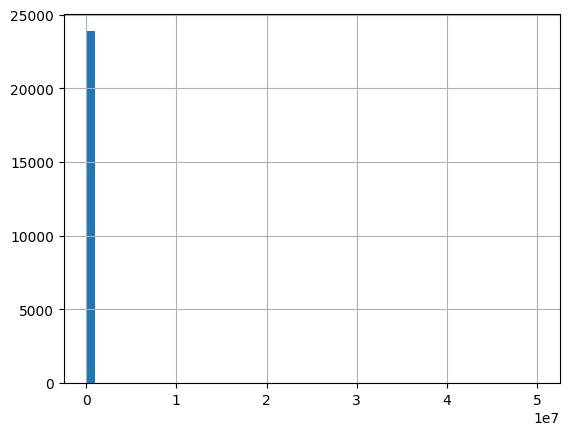

In [7]:
survey['ConvertedCompYearly'].hist(bins=50)

In [8]:
# ConvertedCompYearly will be the target variable but seems to have some outliers
# i will therefore only consider salaries below 200000 in Germany

survey = survey[survey['Country'] == 'Germany']
survey = survey[survey['ConvertedCompYearly'] <= 200000]

<Axes: >

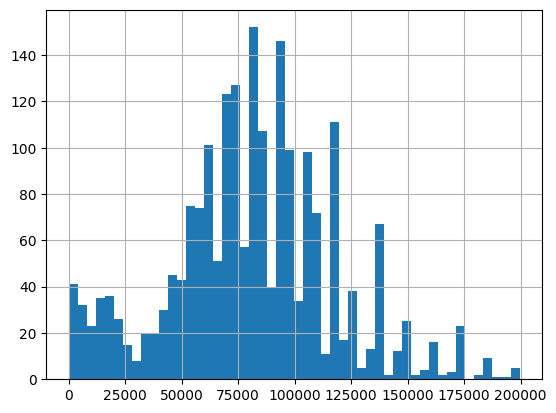

In [9]:
survey['ConvertedCompYearly'].hist(bins=50)

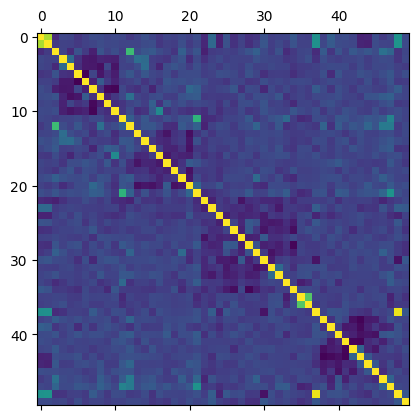

In [10]:
#plot a correlation matrix with the numeric columns
cormat = survey.select_dtypes(include='number').corr()
plt.matshow(cormat)
plt.show()

In [11]:
#This is still too many features. Lets take only the highest values
masked = cormat.mask(np.tril(np.ones(cormat.shape)).astype(np.bool))
sortpairs = masked.unstack().sort_values(kind="quicksort").reset_index()
sortpairs[0]
sortpairs[sortpairs[0].notna() & (abs(sortpairs[0])>0.2)]

,level_0,level_1,0
0,TechEndorse_5,TechEndorse_4,-0.242753
1,SO_Actions_6,SO_Actions_1,-0.231608
2,SO_Actions_6,SO_Actions_4,-0.230968
3,TechEndorse_9,TechEndorse_6,-0.227713
4,JobSatPoints_16,JobSatPoints_9,-0.226914
5,SO_Actions_5,SO_Actions_4,-0.225233
6,TechEndorse_8,TechEndorse_6,-0.213111
7,SO_Actions_6,SO_Actions_16,-0.209247
1208,TechOppose_2,TechEndorse_2,0.203350
1209,TechOppose_1,TechEndorse_7,0.213121


<h2>2. Preprocessing</h2>

In [12]:
# identify and process remaining text columns
# only use categories with at least 10 occurrences
# credit of this box: GPT-5

# 1. Identify multi-choice and single-choice columns
multi_choice_cols = [
    col for col in survey.columns
    if survey[col].dropna().astype(str).str.contains(";").any()
]
single_choice_cols = [
    col for col in survey.columns
    if col not in multi_choice_cols and survey[col].dtype == "object"
]

# 2. Function to process one column with MultiLabelBinarizer
def process_multilabel_column(df, col, min_freq=2):
    # Split strings on ';'
    split_values = df[col].dropna().astype(str).apply(lambda x: x.split(";"))
    
    # Fit binarizer
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(split_values)
    encoded_df = pd.DataFrame(encoded, columns=mlb.classes_, index=split_values.index)
    
    # Drop rare categories (appear < min_freq times)
    freq = encoded_df.sum(axis=0)
    keep_cols = freq[freq >= min_freq].index
    encoded_df = encoded_df[keep_cols]
    
    # Rename columns with prefix to avoid collisions
    encoded_df = encoded_df.add_prefix(f"{col}_")
    
    return encoded_df

# Function to process single-choice categorical columns
def process_singlelabel_column(df, col, min_freq=2):
    # Count frequencies
    freq = df[col].value_counts()
    keep_values = freq[freq >= min_freq].index
    
    # Replace rare categories with "Other"
    filtered = df[col].where(df[col].isin(keep_values), "Other")
    
    # One-hot encode
    encoded_df = pd.get_dummies(filtered, prefix=col)
    
    return encoded_df


print(f"Original shape: {survey.shape}")
survey = survey.dropna(subset=["ConvertedCompYearly"]).reset_index(drop=True)
print(f"After dropping rows with missing target, shape: {survey.shape}")

# 3. Apply to all multi-choice columns
processed_dfs = []
for col in multi_choice_cols:
    processed_dfs.append(process_multilabel_column(survey, col, min_freq=10))
for col in single_choice_cols:
    processed_dfs.append(process_singlelabel_column(survey, col, min_freq=10))

# Concatenate processed features
final_features = pd.concat(processed_dfs, axis=1)


# 4. Join back with original (dropping raw multi-choice cols if desired)
survey_processed = pd.concat([survey.drop(columns=multi_choice_cols).drop(columns=single_choice_cols), final_features], axis=1)

print(f"Final processed shape: {survey_processed.shape}")

Original shape: (2099, 165)
After dropping rows with missing target, shape: (2099, 165)
Final processed shape: (2099, 1302)


In [13]:
#remove CompTotal and ConvertedCompYearly as well as JobSatPoints_11 (Competitive pay and benefits) from the feature set and define the target variable
X=survey_processed.drop(['CompTotal','ConvertedCompYearly','JobSatPoints_11'],axis=1)
y=survey_processed['ConvertedCompYearly']
print(X.shape,y.shape)

(2099, 1299) (2099,)


In [14]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1574, 1299) (525, 1299) (1574,) (525,)


<h2>2. Fit a simple model and evaluate it</h2>

In [15]:
#DecisionTreeRegressor does not handle missing values, so we will fill them with the mean of the respective columns
X_train_simple = X_train.fillna(X_train.mean())
X_test_simple = X_test.fillna(X_test.mean())

In [16]:
simple_model = DecisionTreeRegressor(max_depth=3, random_state=42)
simple_model.fit(X_train_simple, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [17]:
y_pred_train_simple= simple_model.predict(X_train_simple)
print('train rmse',root_mean_squared_error(y_pred_train_simple,y_train))
y_pred_simple = simple_model.predict(X_test_simple)
print('test rmse',root_mean_squared_error(y_pred_simple,y_test))
print('test r2',r2_score(y_test,y_pred_simple))

train rmse 30518.08451575434
test rmse 29971.832902227943
test r2 0.30510802580171514


<h2>3. Fit a more complex model and evaluate it</h2>

In [18]:
complex_model = HistGradientBoostingRegressor(l2_regularization=1.0, learning_rate=0.05, max_depth=3, max_iter=200, min_samples_leaf=20, random_state=42)
complex_model.fit(X_train,y_train)

,loss,'squared_error'
,quantile,None
,learning_rate,0.05
,max_iter,200
,max_leaf_nodes,31
,max_depth,3
,min_samples_leaf,20
,l2_regularization,1.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [19]:
y_pred_train_complex= complex_model.predict(X_train)
print('train rmse',root_mean_squared_error(y_pred_train_complex,y_train))
y_pred_complex= complex_model.predict(X_test)
print('test rmse',root_mean_squared_error(y_pred_complex,y_test))
print('test r2',r2_score(y_test,y_pred_complex))

train rmse 20475.523220128416
test rmse 25864.688303334893
test r2 0.4825061552239963


<h2>4. Compare the 2 models</h2>
The complex model performs significantly better overall compared to the simple model. The RMSE is lower and the R2 score is higher.

<h2>5. Analyze for feature importance </h2>

In [20]:
# use the shap library to analyze feature importance

# Convert boolean columns to int for SHAP compatibility
X_train_shap = X_train.copy()
for col in X_train_shap.select_dtypes(include='bool').columns:
	X_train_shap[col] = X_train_shap[col].astype(int)

x100 = shap.utils.sample(X_train_shap, 100, random_state=42)
explainer = shap.Explainer(complex_model, x100)
shap_values = explainer(X_train_shap)

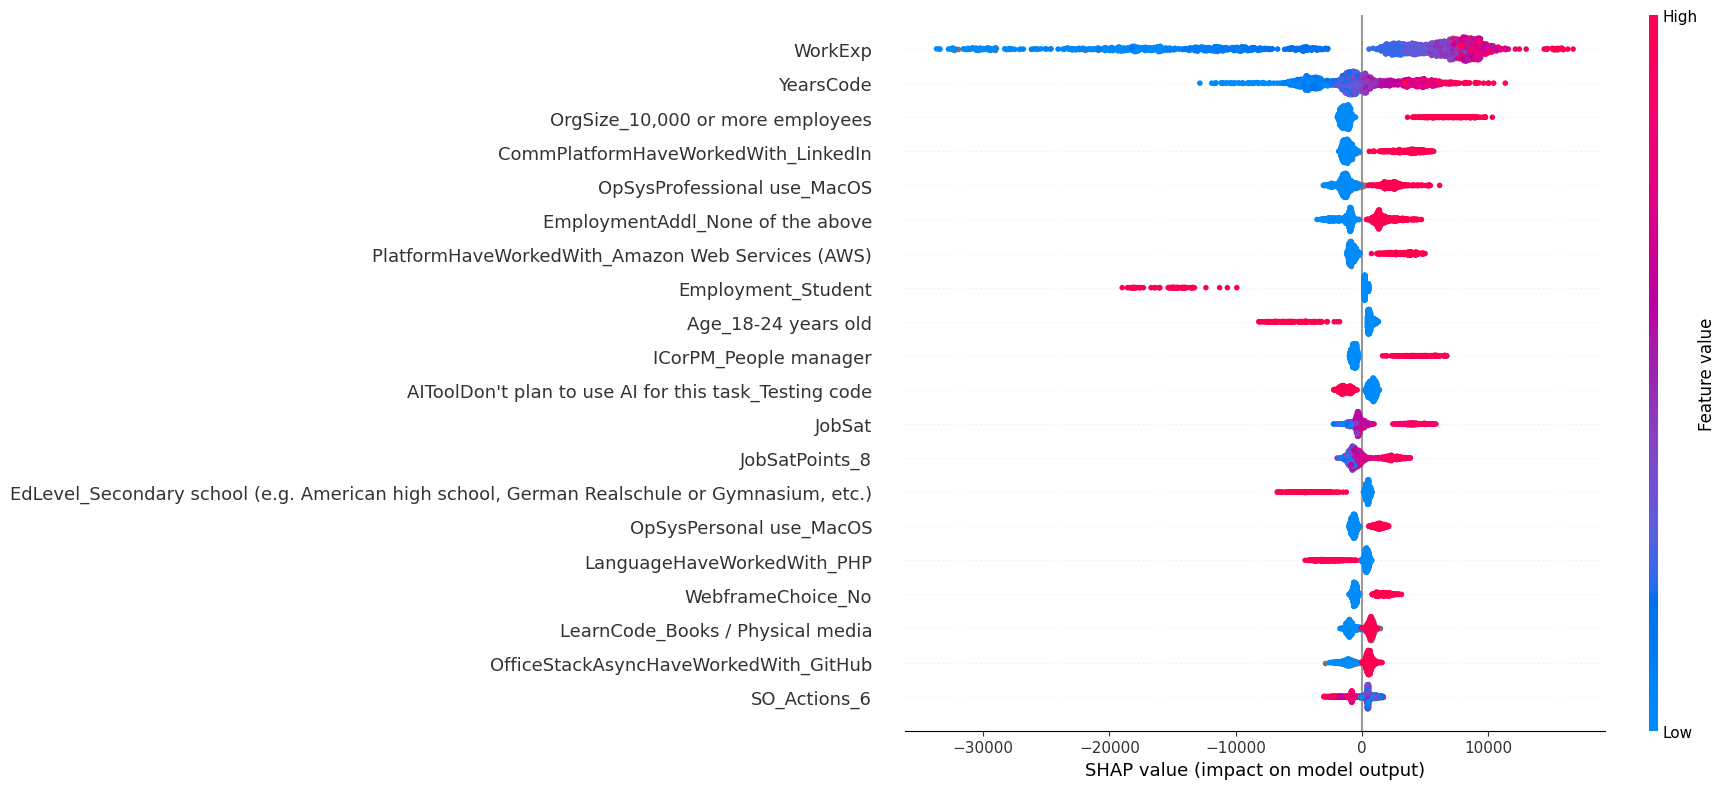

In [21]:
shap.summary_plot(shap_values, X_train_shap, plot_size=[18,8])

Work experience, organization size and tools used seem to be the most important features in predicting salary.

<h2> Draw conclusions </h2>
Overall, the complex model is better at predicting salaries than the simple model. <br/>
However, predicting salaries is inherently difficult due to the many factors that influence salary that are not captured in the data set, such as soft skills including negotiation skills.